# Gromore basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from numpy import asarray
from numpy import savetxt

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Delete Packages
# dir = "/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/GroMore_Project/amanda/scenario5"
# #dir = "C:\Users\vivek\Documents\UA Coursework\HWRS 582 Groundwater Modelling\GroMore_Project\Vivek\Scenario 1"
# #dir = "/Users/hardknox47/Desktop/HWRS482/hw482/GroMore_Project/Justin"

# files = os.listdir(dir)
# ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
#      '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
#      '.lis','.chd','.ddn','.sloc']
# for file in files:
#     for i in range(0,len(ext)):
#         if file.endswith(ext[i]):
#             os.remove(os.path.join(dir,file))

flopy is installed in C:\Users\vivek\Anaconda3\lib\site-packages\flopy


# Scenario 5: Post agriculture model with seasonality - future projection
Add the proposed agricultural element (pumping and localized recharge) for growing pistachios to your post-development model with seasonality. Agriculture starts now, 100 years after the end of the burn-in. Both pumping and recharge related to agriculture occur at the rates described and are continuous throughout the year.

## 2. Discretization and other inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-6 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)
ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), 
        int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

rip_ET= 25e-6  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), 
        int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

extinction_depth = 10 #m

## Recharge
rech=4e-5  #m/d
rechag=0.00015#*0.125  # (0.0001, 0.00015, 0.0002) m/day (wheat, pistachios, cotton)

rechxy=[(0,0),(0,36000)]  #recharge zone

#rechag_rows=(28,29)
#rechag_cols=(18,19)

rechag_rows=(27,29)
rechag_cols=(17,19)

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone = np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),
          int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
rech_zone[0,int(rechag_rows[0]):int(rechag_rows[1]),
          int(rechag_cols[0]):int(rechag_cols[1])]=rechag
#print("recharge location forced(col, row)", rech_cols_forced,rech_rows_forced)

# Setting up wells
#pumping1 = 0 # m3/day      -1500 pumping rate for water supply well  
pumping2 = -4500#*0.125 # m^3/d   (-3000,-4500,-6000) irrigation well pumping rate (wheat, pistachios, cotton)

#well_agua = [2,29,37, pumping1] #Well loc (layer, row, column)
well_ag = [0,38,12, pumping2] #Well loc (layer, row, column)
MW1 = [0,25,24,0]
MW2 = [0,37,12,0]

#wel_spd = {0: [well_agua, well_ag, MW1, MW2]}

## init boundary conditions
#h_right = 70

In [3]:
# savetxt('rech_zone.csv', rech_zone[0], delimiter=',')

### Layering

In [4]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 

## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

## Boundary Conditions

In [5]:
#setup initial heads as the end of scenario 2 burn in values (after 200 years w. seasonality)

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[0, :, :] = np.genfromtxt('top_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the top layer with 200 yr burn in vals
H_init[1, :, :] = np.genfromtxt('mid_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the mid layer with 200 yr burn in vals
H_init[2, :, :] = np.genfromtxt('bot_head_postdevel_100yr.csv', delimiter=',', dtype=float)  #initialize the bottom layer with 200 yr burn in vals

#Adding no flow boundaries
#########################

# Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  # 1st col = no flow       
ibound[:,:,49] = -1  # last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

## River Properties

In [6]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#create dictionary of stress period data
riv_spd = {0: riv_sp}

### Setting up seasonality


In [7]:
#We start in October, because that's a water year
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 180       # Length of stress period 1 in days, October-March, no ET
sp2_len = 180      # Length of stress period 2 in days. April - September, regular ET
sim_years = 100       #number of years for transient simulation 
#nper = int(sp_peryr*sim_years + 1) # 201
nper = int(sp_peryr*sim_years)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False # transient flag is false
#steady[0] = True    # initial stress period is steady-state or true

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)#100 repeating sets of the two stress periods
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen*1  
#nstp[0]=1 #for the steady state solution we just want one output

### Setting up seasonal ET

In [8]:
# #Setup alternating ET values
# #ET_zone has the seasonal ET values
                      
# ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
# ET_zone2 = ET_zone * 0 
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET_dict[p] = ET_zone2
#     elif int(p % 2) != 0:
#         ET_dict[p]=ET_zone
#         #print(p)
#     else: 
#         ET_dict[p] = ET_zone2

## Setting up the post development pumping

In [9]:
#addings these pumping wells for aguaseca community well
t=np.arange(0,210,10)
# print(t)
pumping_spd={}
for a in range(0,len(t)):
    pumping_spd[a]=[2,29,37,-(1.5*(t[a])**(1.5))]
# print(pumping_spd)

#Set up the wel data for stress periods, changing well_agua pumping rate
wel_spd = {}  

i=11

for p in range(0,201): #nper = 201
    if (199>p>0 and ((p) % 20) == 0):
        i=i+1
    if (p >= 0 and p <= 21):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 41):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 61):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p<= 81):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 101):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 121):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 141):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 161):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 181):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 201):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    else:
        print('p not in range')

## Set up and run scenario 3

In [10]:
#Initialize the model
modelname = "Scenario_5"
#moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
# moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
moddir="C:\WRDAPP\MODFLOW\mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp = nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

#create rch object
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     


# Attach ET package
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Setting up RIV package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)

#Output control - OC 
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 150)] = ['save head','save drawdown','save budget','print head','print budget']
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
# pcg = flopy.modflow.ModflowPcg(model=m)
#Numerical solver - pcg
#pcg = flopy.modflow.ModflowPcg(model=m, mxiter=1000, iter1=100, relax = 0.95, damp = 0.5)
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=100, relax = 0.95, damp = 0.1)

#write the inputs
m.write_input()   

m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()

check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative 

In [11]:
#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: C:\WRDAPP\MODFLOW\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario_5.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/28  0:06:35

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     8   

 Solving:  Stress period:     1    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:   114    Ground-Wa

 Solving:  Stress period:     2    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    40    Ground-Wa

 Solving:  Stress period:     2    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   147    Ground-Wa

 Solving:  Stress period:     3    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    75    Ground-Wa

 Solving:  Stress period:     3    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Wa

 Solving:  Stress period:     4    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   109    Ground-Wa

 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    36    Ground-Wa

 Solving:  Stress period:     5    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   144    Ground-Wa

 Solving:  Stress period:     6    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    72    Ground-Wa

 Solving:  Stress period:     6    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:   180    Ground-Wa

 Solving:  Stress period:     7    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   106    Ground-Wa

 Solving:  Stress period:     8    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    34    Ground-Wa

 Solving:  Stress period:     8    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   141    Ground-Wa

 Solving:  Stress period:     9    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    69    Ground-Wa

 Solving:  Stress period:     9    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   175    Ground-Wa

 Solving:  Stress period:    10    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   103    Ground-Wa

 Solving:  Stress period:    11    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    29    Ground-Wa

 Solving:  Stress period:    11    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:   135    Ground-Wa

 Solving:  Stress period:    12    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    64    Ground-Wa

 Solving:  Stress period:    12    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   170    Ground-Wa

 Solving:  Stress period:    13    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    97    Ground-Wa

 Solving:  Stress period:    14    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    23    Ground-Wa

 Solving:  Stress period:    14    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   129    Ground-Wa

 Solving:  Stress period:    15    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    57    Ground-Wa

 Solving:  Stress period:    15    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   165    Ground-Wa

 Solving:  Stress period:    16    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    93    Ground-Wa

 Solving:  Stress period:    17    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    21    Ground-Wa

 Solving:  Stress period:    17    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   130    Ground-Wa

 Solving:  Stress period:    18    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    57    Ground-Wa

 Solving:  Stress period:    18    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   164    Ground-Wa

 Solving:  Stress period:    19    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    93    Ground-Wa

 Solving:  Stress period:    20    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    19    Ground-Wa

 Solving:  Stress period:    20    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   127    Ground-Wa

 Solving:  Stress period:    21    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    52    Ground-Wa

 Solving:  Stress period:    21    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   160    Ground-Wa

 Solving:  Stress period:    22    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    86    Ground-Wa

 Solving:  Stress period:    23    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    14    Ground-Wa

 Solving:  Stress period:    23    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   120    Ground-Wa

 Solving:  Stress period:    24    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    46    Ground-Wa

 Solving:  Stress period:    24    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   154    Ground-Wa

 Solving:  Stress period:    25    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    81    Ground-Wa

 Solving:  Stress period:    25    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     7    Ground-Wa

 Solving:  Stress period:    26    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:   115    Ground-Wa

 Solving:  Stress period:    27    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    41    Ground-Wa

 Solving:  Stress period:    27    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   149    Ground-Wa

 Solving:  Stress period:    28    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    75    Ground-Wa

 Solving:  Stress period:    28    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     3    Ground-Wa

 Solving:  Stress period:    29    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   111    Ground-Wa

 Solving:  Stress period:    30    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    37    Ground-Wa

 Solving:  Stress period:    30    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   144    Ground-Wa

 Solving:  Stress period:    31    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    73    Ground-Wa

 Solving:  Stress period:    31    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     2    Ground-Wa

 Solving:  Stress period:    32    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   110    Ground-Wa

 Solving:  Stress period:    33    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    37    Ground-Wa

 Solving:  Stress period:    33    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   145    Ground-Wa

 Solving:  Stress period:    34    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    74    Ground-Wa

 Solving:  Stress period:    34    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     2    Ground-Wa

 Solving:  Stress period:    35    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   110    Ground-Wa

 Solving:  Stress period:    36    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    38    Ground-Wa

 Solving:  Stress period:    36    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   145    Ground-Wa

 Solving:  Stress period:    37    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    72    Ground-Wa

 Solving:  Stress period:    37    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   179    Ground-Wa

 Solving:  Stress period:    38    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   107    Ground-Wa

 Solving:  Stress period:    39    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    35    Ground-Wa

 Solving:  Stress period:    39    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:   142    Ground-Wa

 Solving:  Stress period:    40    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    70    Ground-Wa

 Solving:  Stress period:    40    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   177    Ground-Wa

 Solving:  Stress period:    41    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   105    Ground-Wa

 Solving:  Stress period:    42    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:    33    Ground-Wa

 Solving:  Stress period:    42    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   141    Ground-Wa

 Solving:  Stress period:    43    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    68    Ground-Wa

 Solving:  Stress period:    43    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   177    Ground-Wa

 Solving:  Stress period:    44    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   105    Ground-Wa

 Solving:  Stress period:    45    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    33    Ground-Wa

 Solving:  Stress period:    45    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   140    Ground-Wa

 Solving:  Stress period:    46    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    67    Ground-Wa

 Solving:  Stress period:    46    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:   175    Ground-Wa

 Solving:  Stress period:    47    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   102    Ground-Wa

 Solving:  Stress period:    48    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    30    Ground-Wa

 Solving:  Stress period:    48    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:   138    Ground-Wa

 Solving:  Stress period:    49    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    66    Ground-Wa

 Solving:  Stress period:    49    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   174    Ground-Wa

 Solving:  Stress period:    50    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   100    Ground-Wa

 Solving:  Stress period:    51    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    27    Ground-Wa

 Solving:  Stress period:    51    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   136    Ground-Wa

 Solving:  Stress period:    52    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    62    Ground-Wa

 Solving:  Stress period:    52    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:   168    Ground-Wa

 Solving:  Stress period:    53    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    95    Ground-Wa

 Solving:  Stress period:    54    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    23    Ground-Wa

 Solving:  Stress period:    54    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:   131    Ground-Wa

 Solving:  Stress period:    55    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    58    Ground-Wa

 Solving:  Stress period:    55    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   165    Ground-Wa

 Solving:  Stress period:    56    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    93    Ground-Wa

 Solving:  Stress period:    57    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    19    Ground-Wa

 Solving:  Stress period:    57    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   127    Ground-Wa

 Solving:  Stress period:    58    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    55    Ground-Wa

 Solving:  Stress period:    58    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   163    Ground-Wa

 Solving:  Stress period:    59    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    91    Ground-Wa

 Solving:  Stress period:    60    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    19    Ground-Wa

 Solving:  Stress period:    60    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   127    Ground-Wa

 Solving:  Stress period:    61    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    53    Ground-Wa

 Solving:  Stress period:    61    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   160    Ground-Wa

 Solving:  Stress period:    62    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    88    Ground-Wa

 Solving:  Stress period:    63    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:    16    Ground-Wa

 Solving:  Stress period:    63    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   124    Ground-Wa

 Solving:  Stress period:    64    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    52    Ground-Wa

 Solving:  Stress period:    64    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   160    Ground-Wa

 Solving:  Stress period:    65    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    88    Ground-Wa

 Solving:  Stress period:    66    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    16    Ground-Wa

 Solving:  Stress period:    66    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   124    Ground-Wa

 Solving:  Stress period:    67    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    52    Ground-Wa

 Solving:  Stress period:    67    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   160    Ground-Wa

 Solving:  Stress period:    68    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    88    Ground-Wa

 Solving:  Stress period:    69    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    15    Ground-Wa

 Solving:  Stress period:    69    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   123    Ground-Wa

 Solving:  Stress period:    70    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    51    Ground-Wa

 Solving:  Stress period:    70    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   159    Ground-Wa

 Solving:  Stress period:    71    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    87    Ground-Wa

 Solving:  Stress period:    72    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    16    Ground-Wa

 Solving:  Stress period:    72    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   124    Ground-Wa

 Solving:  Stress period:    73    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    52    Ground-Wa

 Solving:  Stress period:    73    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   160    Ground-Wa

 Solving:  Stress period:    74    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    87    Ground-Wa

 Solving:  Stress period:    75    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    15    Ground-Wa

 Solving:  Stress period:    75    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:   123    Ground-Wa

 Solving:  Stress period:    76    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    50    Ground-Wa

 Solving:  Stress period:    76    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   158    Ground-Wa

 Solving:  Stress period:    77    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    87    Ground-Wa

 Solving:  Stress period:    78    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    15    Ground-Wa

 Solving:  Stress period:    78    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   123    Ground-Wa

 Solving:  Stress period:    79    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    51    Ground-Wa

 Solving:  Stress period:    79    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:   157    Ground-Wa

 Solving:  Stress period:    80    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    82    Ground-Wa

 Solving:  Stress period:    80    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     8    Ground-Wa

 Solving:  Stress period:    81    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   115    Ground-Wa

 Solving:  Stress period:    82    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    41    Ground-Wa

 Solving:  Stress period:    82    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   148    Ground-Wa

 Solving:  Stress period:    83    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    76    Ground-Wa

 Solving:  Stress period:    83    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     3    Ground-Wa

 Solving:  Stress period:    84    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   109    Ground-Wa

 Solving:  Stress period:    85    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    35    Ground-Wa

 Solving:  Stress period:    85    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:   141    Ground-Wa

 Solving:  Stress period:    86    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    69    Ground-Wa

 Solving:  Stress period:    86    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   178    Ground-Wa

 Solving:  Stress period:    87    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:   107    Ground-Wa

 Solving:  Stress period:    88    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    34    Ground-Wa

 Solving:  Stress period:    88    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   140    Ground-Wa

 Solving:  Stress period:    89    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    68    Ground-Wa

 Solving:  Stress period:    89    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   174    Ground-Wa

 Solving:  Stress period:    90    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   102    Ground-Wa

 Solving:  Stress period:    91    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    28    Ground-Wa

 Solving:  Stress period:    91    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   137    Ground-Wa

 Solving:  Stress period:    92    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    63    Ground-Wa

 Solving:  Stress period:    92    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   169    Ground-Wa

 Solving:  Stress period:    93    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    95    Ground-Wa

 Solving:  Stress period:    94    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    24    Ground-Wa

 Solving:  Stress period:    94    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   133    Ground-Wa

 Solving:  Stress period:    95    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    62    Ground-Wa

 Solving:  Stress period:    95    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:   171    Ground-Wa

 Solving:  Stress period:    96    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    97    Ground-Wa

 Solving:  Stress period:    97    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    26    Ground-Wa

 Solving:  Stress period:    97    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:   135    Ground-Wa

 Solving:  Stress period:    98    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    61    Ground-Wa

 Solving:  Stress period:    98    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   169    Ground-Wa

 Solving:  Stress period:    99    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    97    Ground-Wa

 Solving:  Stress period:   100    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    24    Ground-Wa

 Solving:  Stress period:   100    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   130    Ground-Wa

 Solving:  Stress period:   101    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    59    Ground-Wa

 Solving:  Stress period:   101    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   167    Ground-Wa

 Solving:  Stress period:   102    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    93    Ground-Wa

 Solving:  Stress period:   103    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    20    Ground-Wa

 Solving:  Stress period:   103    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:   128    Ground-Wa

 Solving:  Stress period:   104    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    55    Ground-Wa

 Solving:  Stress period:   104    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   162    Ground-Wa

 Solving:  Stress period:   105    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    91    Ground-Wa

 Solving:  Stress period:   106    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    18    Ground-Wa

 Solving:  Stress period:   106    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   124    Ground-Wa

 Solving:  Stress period:   107    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    50    Ground-Wa

 Solving:  Stress period:   107    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:   158    Ground-Wa

 Solving:  Stress period:   108    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    87    Ground-Wa

 Solving:  Stress period:   109    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    14    Ground-Wa

 Solving:  Stress period:   109    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   121    Ground-Wa

 Solving:  Stress period:   110    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    49    Ground-Wa

 Solving:  Stress period:   110    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   155    Ground-Wa

 Solving:  Stress period:   111    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    82    Ground-Wa

 Solving:  Stress period:   111    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    10    Ground-Wa

 Solving:  Stress period:   112    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   118    Ground-Wa

 Solving:  Stress period:   113    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    44    Ground-Wa

 Solving:  Stress period:   113    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   152    Ground-Wa

 Solving:  Stress period:   114    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    77    Ground-Wa

 Solving:  Stress period:   114    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     3    Ground-Wa

 Solving:  Stress period:   115    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   112    Ground-Wa

 Solving:  Stress period:   116    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    39    Ground-Wa

 Solving:  Stress period:   116    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   145    Ground-Wa

 Solving:  Stress period:   117    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    71    Ground-Wa

 Solving:  Stress period:   117    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   180    Ground-Wa

 Solving:  Stress period:   118    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   109    Ground-Wa

 Solving:  Stress period:   119    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    38    Ground-Wa

 Solving:  Stress period:   119    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   146    Ground-Wa

 Solving:  Stress period:   120    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    72    Ground-Wa

 Solving:  Stress period:   120    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   179    Ground-Wa

 Solving:  Stress period:   121    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   105    Ground-Wa

 Solving:  Stress period:   122    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    33    Ground-Wa

 Solving:  Stress period:   122    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   141    Ground-Wa

 Solving:  Stress period:   123    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    67    Ground-Wa

 Solving:  Stress period:   123    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   176    Ground-Wa

 Solving:  Stress period:   124    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:   102    Ground-Wa

 Solving:  Stress period:   125    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    28    Ground-Wa

 Solving:  Stress period:   125    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   135    Ground-Wa

 Solving:  Stress period:   126    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    63    Ground-Wa

 Solving:  Stress period:   126    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:   169    Ground-Wa

 Solving:  Stress period:   127    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    96    Ground-Wa

 Solving:  Stress period:   128    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    24    Ground-Wa

 Solving:  Stress period:   128    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   131    Ground-Wa

 Solving:  Stress period:   129    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    60    Ground-Wa

 Solving:  Stress period:   129    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   167    Ground-Wa

 Solving:  Stress period:   130    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    96    Ground-Wa

 Solving:  Stress period:   131    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:    22    Ground-Wa

 Solving:  Stress period:   131    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   129    Ground-Wa

 Solving:  Stress period:   132    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    57    Ground-Wa

 Solving:  Stress period:   132    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   166    Ground-Wa

 Solving:  Stress period:   133    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    93    Ground-Wa

 Solving:  Stress period:   134    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    22    Ground-Wa

 Solving:  Stress period:   134    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   130    Ground-Wa

 Solving:  Stress period:   135    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    56    Ground-Wa

 Solving:  Stress period:   135    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:   162    Ground-Wa

 Solving:  Stress period:   136    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    90    Ground-Wa

 Solving:  Stress period:   137    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    18    Ground-Wa

 Solving:  Stress period:   137    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   126    Ground-Wa

 Solving:  Stress period:   138    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    53    Ground-Wa

 Solving:  Stress period:   138    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   161    Ground-Wa

 Solving:  Stress period:   139    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    88    Ground-Wa

 Solving:  Stress period:   140    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    15    Ground-Wa

 Solving:  Stress period:   140    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   123    Ground-Wa

 Solving:  Stress period:   141    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    51    Ground-Wa

 Solving:  Stress period:   141    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   160    Ground-Wa

 Solving:  Stress period:   142    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    89    Ground-Wa

 Solving:  Stress period:   143    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    16    Ground-Wa

 Solving:  Stress period:   143    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   123    Ground-Wa

 Solving:  Stress period:   144    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    50    Ground-Wa

 Solving:  Stress period:   144    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   157    Ground-Wa

 Solving:  Stress period:   145    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    85    Ground-Wa

 Solving:  Stress period:   146    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    15    Ground-Wa

 Solving:  Stress period:   146    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   124    Ground-Wa

 Solving:  Stress period:   147    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    54    Ground-Wa

 Solving:  Stress period:   147    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   161    Ground-Wa

 Solving:  Stress period:   148    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    89    Ground-Wa

 Solving:  Stress period:   149    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    17    Ground-Wa

 Solving:  Stress period:   149    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   125    Ground-Wa

 Solving:  Stress period:   150    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    51    Ground-Wa

 Solving:  Stress period:   150    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   157    Ground-Wa

 Solving:  Stress period:   151    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    84    Ground-Wa

 Solving:  Stress period:   151    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    10    Ground-Wa

 Solving:  Stress period:   152    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:   119    Ground-Wa

 Solving:  Stress period:   153    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    47    Ground-Wa

 Solving:  Stress period:   153    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   153    Ground-Wa

 Solving:  Stress period:   154    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    80    Ground-Wa

 Solving:  Stress period:   154    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     9    Ground-Wa

 Solving:  Stress period:   155    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   115    Ground-Wa

 Solving:  Stress period:   156    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    45    Ground-Wa

 Solving:  Stress period:   156    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   153    Ground-Wa

 Solving:  Stress period:   157    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    80    Ground-Wa

 Solving:  Stress period:   157    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:     9    Ground-Wa

 Solving:  Stress period:   158    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   117    Ground-Wa

 Solving:  Stress period:   159    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    47    Ground-Wa

 Solving:  Stress period:   159    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   155    Ground-Wa

 Solving:  Stress period:   160    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    84    Ground-Wa

 Solving:  Stress period:   161    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    14    Ground-Wa

 Solving:  Stress period:   161    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   120    Ground-Wa

 Solving:  Stress period:   162    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    46    Ground-Wa

 Solving:  Stress period:   162    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   155    Ground-Wa

 Solving:  Stress period:   163    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    83    Ground-Wa

 Solving:  Stress period:   163    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     9    Ground-Wa

 Solving:  Stress period:   164    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   116    Ground-Wa

 Solving:  Stress period:   165    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    44    Ground-Wa

 Solving:  Stress period:   165    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   150    Ground-Wa

 Solving:  Stress period:   166    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    79    Ground-Wa

 Solving:  Stress period:   166    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:     5    Ground-Wa

 Solving:  Stress period:   167    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   111    Ground-Wa

 Solving:  Stress period:   168    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    37    Ground-Wa

 Solving:  Stress period:   168    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   143    Ground-Wa

 Solving:  Stress period:   169    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    71    Ground-Wa

 Solving:  Stress period:   169    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:     1    Ground-Wa

 Solving:  Stress period:   170    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   108    Ground-Wa

 Solving:  Stress period:   171    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    36    Ground-Wa

 Solving:  Stress period:   171    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   142    Ground-Wa

 Solving:  Stress period:   172    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    69    Ground-Wa

 Solving:  Stress period:   172    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   175    Ground-Wa

 Solving:  Stress period:   173    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   101    Ground-Wa

 Solving:  Stress period:   174    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    27    Ground-Wa

 Solving:  Stress period:   174    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   137    Ground-Wa

 Solving:  Stress period:   175    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    65    Ground-Wa

 Solving:  Stress period:   175    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   174    Ground-Wa

 Solving:  Stress period:   176    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   101    Ground-Wa

 Solving:  Stress period:   177    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    30    Ground-Wa

 Solving:  Stress period:   177    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   140    Ground-Wa

 Solving:  Stress period:   178    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    67    Ground-Wa

 Solving:  Stress period:   178    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   176    Ground-Wa

 Solving:  Stress period:   179    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   105    Ground-Wa

 Solving:  Stress period:   180    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    31    Ground-Wa

 Solving:  Stress period:   180    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   140    Ground-Wa

 Solving:  Stress period:   181    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    68    Ground-Wa

 Solving:  Stress period:   181    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:   175    Ground-Wa

 Solving:  Stress period:   182    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   104    Ground-Wa

 Solving:  Stress period:   183    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    30    Ground-Wa

 Solving:  Stress period:   183    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   136    Ground-Wa

 Solving:  Stress period:   184    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    65    Ground-Wa

 Solving:  Stress period:   184    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   173    Ground-Wa

 Solving:  Stress period:   185    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   102    Ground-Wa

 Solving:  Stress period:   186    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    31    Ground-Wa

 Solving:  Stress period:   186    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   138    Ground-Wa

 Solving:  Stress period:   187    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    65    Ground-Wa

 Solving:  Stress period:   187    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:   171    Ground-Wa

 Solving:  Stress period:   188    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    98    Ground-Wa

 Solving:  Stress period:   189    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    28    Ground-Wa

 Solving:  Stress period:   189    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:   138    Ground-Wa

 Solving:  Stress period:   190    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    67    Ground-Wa

 Solving:  Stress period:   190    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   174    Ground-Wa

 Solving:  Stress period:   191    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   103    Ground-Wa

 Solving:  Stress period:   192    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    31    Ground-Wa

 Solving:  Stress period:   192    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   138    Ground-Wa

 Solving:  Stress period:   193    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    67    Ground-Wa

 Solving:  Stress period:   193    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   177    Ground-Wa

 Solving:  Stress period:   194    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   105    Ground-Wa

 Solving:  Stress period:   195    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    33    Ground-Wa

 Solving:  Stress period:   195    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   141    Ground-Wa

 Solving:  Stress period:   196    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    67    Ground-Wa

 Solving:  Stress period:   196    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   174    Ground-Wa

 Solving:  Stress period:   197    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   104    Ground-Wa

 Solving:  Stress period:   198    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    34    Ground-Wa

 Solving:  Stress period:   198    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   140    Ground-Wa

 Solving:  Stress period:   199    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    67    Ground-Wa

 Solving:  Stress period:   199    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   176    Ground-Wa

 Solving:  Stress period:   200    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   105    Ground-Wa

## Checking domain

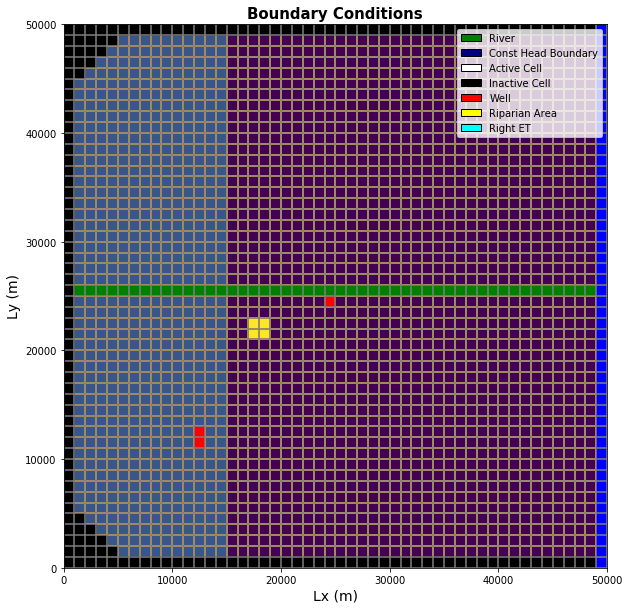

In [12]:
#CHECK BOUNDARY CONDITIONS
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#zones = ET_zone + rech_zone
#quadmesh = modelmap.plot_array(zones)
recharge = modelmap.plot_array((rech_zone), color = 'orange')
#ET = modelmap.plot_array(ET_zone)
riv_plot = modelmap.plot_bc(ftype='RIV')
wel_plot = modelmap.plot_bc(ftype='WEL')
quadmesh = modelmap.plot_ibound()

#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                   mp.patches.Patch(color='navy',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='Red',label='Well',ec='black'),
                   mp.patches.Patch(color='Yellow',label='Riparian Area',ec='black'),
                   mp.patches.Patch(color='cyan',label='Right ET',ec='black')],)

## Read in the outputs

In [13]:
modelname = "Scenario_5"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data 
frf = {} #create dictionary to store flows through right cell face 
fff = {} #create dictionary to store flows through front cell face 
storage = {} #create dictionary to store storage
ET = {}

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data() #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) 
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
    storage['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
    ET['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
print(times)

[182.0, 271.0, 331.0, 362.0, 451.0, 511.0, 542.0, 631.0, 691.0, 722.0, 811.0, 871.0, 902.0, 991.0, 1051.0, 1082.0, 1171.0, 1231.0, 1262.0, 1351.0, 1411.0, 1442.0, 1531.0, 1591.0, 1622.0, 1711.0, 1771.0, 1802.0, 1891.0, 1951.0, 1982.0, 2071.0, 2131.0, 2162.0, 2251.0, 2311.0, 2342.0, 2431.0, 2491.0, 2522.0, 2611.0, 2671.0, 2702.0, 2791.0, 2851.0, 2882.0, 2971.0, 3031.0, 3062.0, 3151.0, 3211.0, 3242.0, 3331.0, 3391.0, 3422.0, 3511.0, 3571.0, 3602.0, 3691.0, 3751.0, 3782.0, 3871.0, 3931.0, 3962.0, 4051.0, 4111.0, 4142.0, 4231.0, 4291.0, 4322.0, 4411.0, 4471.0, 4502.0, 4591.0, 4651.0, 4682.0, 4771.0, 4831.0, 4862.0, 4951.0, 5011.0, 5042.0, 5131.0, 5191.0, 5222.0, 5311.0, 5371.0, 5402.0, 5491.0, 5551.0, 5582.0, 5671.0, 5731.0, 5762.0, 5851.0, 5911.0, 5942.0, 6031.0, 6091.0, 6122.0, 6211.0, 6271.0, 6302.0, 6391.0, 6451.0, 6482.0, 6571.0, 6631.0, 6662.0, 6751.0, 6811.0, 6842.0, 6931.0, 6991.0, 7022.0, 7111.0, 7171.0, 7202.0, 7291.0, 7351.0, 7382.0, 7471.0, 7531.0, 7562.0, 7651.0, 7711.0, 7742.

## Plot head at monitoring wells

In [14]:
#get time series for a certain cell

cell_id1 = (0,25,24) #cell ID of MW1
cell_id2 = (0,37,12) #cell ID of MW2
ag_id = (0,38,12)#cell ID of ag well
agua_id = (2,29,37) #Cell ID of aguaseca community well

time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well
#print(time_series_ag)

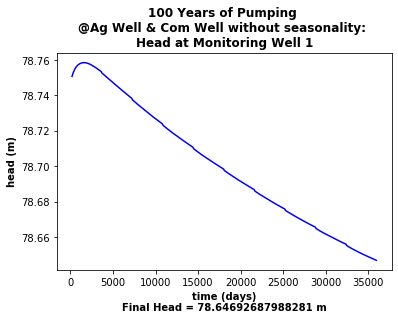

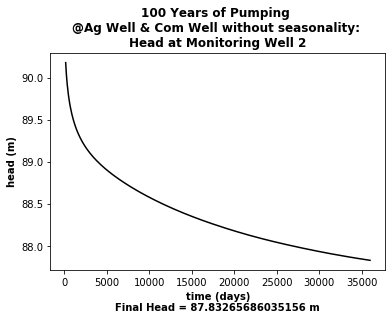

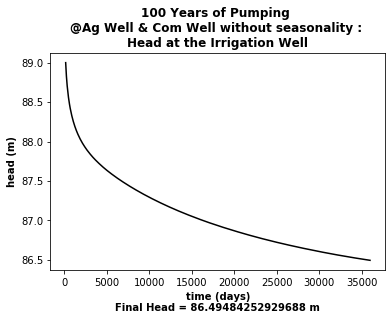

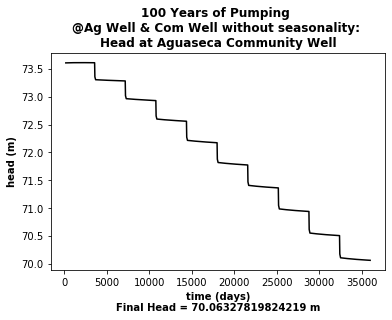

In [21]:

#create plot of MW1
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Ag Well & Com Well without seasonality: \nHead at Monitoring Well 1"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0, 25, 24]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.savefig("Head_M1_S5.png",dpi=600,bbox_inches='tight')
plt.show()

#create plot of MW2
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Ag Well & Com Well without seasonality: \nHead at Monitoring Well 2"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0, 37, 12]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series2[:, 1], 'k-') #plot the time series with points at each record
plt.savefig("Head_M2_S5.png",dpi=600,bbox_inches='tight')
plt.show()

#create plot of Ag well
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Ag Well & Com Well without seasonality : \nHead at the Irrigation Well"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0,38,12]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_ag[:, 0], time_series_ag[:, 1], 'k-') #plot the time series with points at each record
plt.savefig("Head_Aq_S5.png",dpi=600,bbox_inches='tight')
plt.show()

#create plot of Aguaseca com well
plt.subplot(1, 1, 1)
ax=plt.gca()
ax.ticklabel_format(useOffset=False)
plt.title("100 Years of Pumping \n@Ag Well & Com Well without seasonality: \nHead at Aguaseca Community Well"
          ,fontweight='bold')
plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][2, 29, 37]} m",fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_agua[:, 0], time_series_agua[:, 1], 'k-') #plot the time series with points at each record
plt.savefig("Head_Aqua_S5.png",dpi=600,bbox_inches='tight')
plt.show()

## River Leakage

In [16]:
leakage = budgobj.get_data(text='RIVER LEAKAGE')
#print(len(leakage))
#print(head.keys())
#print(head['sp0'][0])
#print(len(leakage))
#print(np.shape(leakage))
#print(leakage)

posit_ET_pos = len(leakage)-4
no_ET_pos = len(leakage)-1

leak=leakage[posit_ET_pos]#time step with positive ET
tot_leak = sum(leak.q)

leak2=leakage[no_ET_pos] #time step with zero ET
tot_leak2 = sum(leak2.q)

print("Total Daily flux from river to groundwater (Oct-March SP)", tot_leak2, "m3/day")
print("Total Daily flux from river to groundwater (Apr-Sept SP)", tot_leak, "m3/day")

Total Daily flux from river to groundwater (Oct-March SP) 10085.025009155273 m3/day
Total Daily flux from river to groundwater (Apr-Sept SP) 10076.046303749084 m3/day


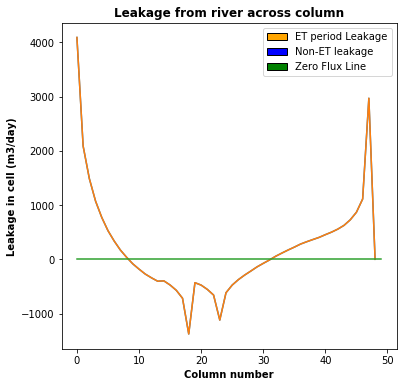

In [17]:
x2 = []
for n in range(0,50):
    x2.append(n)
y2 = np.zeros(50)
fig = plt.figure(figsize=(6, 6))
x = list(range(49))
plt.plot(x, leak.q)
plt.plot(x, leak2.q)
plt.plot(x2, y2)
plt.plot()
plt.title('Leakage from river across column',fontweight='bold')
plt.xlabel('Column number', fontweight = 'bold')
plt.ylabel("Leakage in cell (m3/day)", fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='orange',label='ET period Leakage',ec='black'),
                   mp.patches.Patch(color='blue',label='Non-ET leakage',ec='black'),
                    mp.patches.Patch(color='green',label='Zero Flux Line',ec='black')])
                    
plt.show()

## Water Budget

In [18]:
budgobj.list_records()

(2, 2, b'         STORAGE', 50, 50, -3, 1, 1., 2., 182., b'', b'', b'', b'')
(2, 2, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 2., 182., b'', b'', b'', b'')
(2, 2, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 182., b'', b'', b'', b'')
(2, 2, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 2., 182., b'', b'', b'', b'')
(2, 2, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 2., 182., b'', b'', b'', b'')
(2, 2, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 2., 182., b'', b'', b'', b'')
(2, 2, b'              ET', 50, 50, -3, 3, 1., 2., 182., b'', b'', b'', b'')
(2, 2, b'        RECHARGE', 50, 50, -3, 3, 1., 2., 182., b'', b'', b'', b'')
(91, 2, b'         STORAGE', 50, 50, -3, 1, 1., 91., 271., b'', b'', b'', b'')
(91, 2, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 91., 271., b'', b'', b'', b'')
(91, 2, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 91., 271., b'', b'', b'', b'')
(91, 2, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 91., 271., b'', b'', b'', b'')
(91, 2, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 91., 271., b'', b'',

(151, 15, b'              ET', 50, 50, -3, 3, 1., 151., 2671., b'', b'', b'', b'')
(151, 15, b'        RECHARGE', 50, 50, -3, 3, 1., 151., 2671., b'', b'', b'', b'')
(2, 16, b'         STORAGE', 50, 50, -3, 1, 1., 2., 2702., b'', b'', b'', b'')
(2, 16, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 2., 2702., b'', b'', b'', b'')
(2, 16, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 2702., b'', b'', b'', b'')
(2, 16, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 2., 2702., b'', b'', b'', b'')
(2, 16, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 2., 2702., b'', b'', b'', b'')
(2, 16, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 2., 2702., b'', b'', b'', b'')
(2, 16, b'              ET', 50, 50, -3, 3, 1., 2., 2702., b'', b'', b'', b'')
(2, 16, b'        RECHARGE', 50, 50, -3, 3, 1., 2., 2702., b'', b'', b'', b'')
(91, 16, b'         STORAGE', 50, 50, -3, 1, 1., 91., 2791., b'', b'', b'', b'')
(91, 16, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 91., 2791., b'', b'', b'', b'')
(91, 16, b'FLOW RIGHT FACE ', 50, 50, -3

(91, 30, b'        RECHARGE', 50, 50, -3, 3, 1., 91., 5311., b'', b'', b'', b'')
(151, 30, b'         STORAGE', 50, 50, -3, 1, 1., 151., 5371., b'', b'', b'', b'')
(151, 30, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 151., 5371., b'', b'', b'', b'')
(151, 30, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 151., 5371., b'', b'', b'', b'')
(151, 30, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 151., 5371., b'', b'', b'', b'')
(151, 30, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 151., 5371., b'', b'', b'', b'')
(151, 30, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 151., 5371., b'', b'', b'', b'')
(151, 30, b'              ET', 50, 50, -3, 3, 1., 151., 5371., b'', b'', b'', b'')
(151, 30, b'        RECHARGE', 50, 50, -3, 3, 1., 151., 5371., b'', b'', b'', b'')
(2, 31, b'         STORAGE', 50, 50, -3, 1, 1., 2., 5402., b'', b'', b'', b'')
(2, 31, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 2., 5402., b'', b'', b'', b'')
(2, 31, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 5402., b'', b'', b'', b'')
(2, 31, b'FLOW FRO

(151, 46, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 151., 8251., b'', b'', b'', b'')
(151, 46, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 151., 8251., b'', b'', b'', b'')
(151, 46, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 151., 8251., b'', b'', b'', b'')
(151, 46, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 151., 8251., b'', b'', b'', b'')
(151, 46, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 151., 8251., b'', b'', b'', b'')
(151, 46, b'              ET', 50, 50, -3, 3, 1., 151., 8251., b'', b'', b'', b'')
(151, 46, b'        RECHARGE', 50, 50, -3, 3, 1., 151., 8251., b'', b'', b'', b'')
(2, 47, b'         STORAGE', 50, 50, -3, 1, 1., 2., 8282., b'', b'', b'', b'')
(2, 47, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 2., 8282., b'', b'', b'', b'')
(2, 47, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 8282., b'', b'', b'', b'')
(2, 47, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 2., 8282., b'', b'', b'', b'')
(2, 47, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 2., 8282., b'', b'', b'', b'')
(2, 47, b'   RIVER LEAKA

(151, 62, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 151., 11131., b'', b'', b'', b'')
(151, 62, b'              ET', 50, 50, -3, 3, 1., 151., 11131., b'', b'', b'', b'')
(151, 62, b'        RECHARGE', 50, 50, -3, 3, 1., 151., 11131., b'', b'', b'', b'')
(2, 63, b'         STORAGE', 50, 50, -3, 1, 1., 2., 11162., b'', b'', b'', b'')
(2, 63, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 2., 11162., b'', b'', b'', b'')
(2, 63, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 11162., b'', b'', b'', b'')
(2, 63, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 2., 11162., b'', b'', b'', b'')
(2, 63, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 2., 11162., b'', b'', b'', b'')
(2, 63, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 2., 11162., b'', b'', b'', b'')
(2, 63, b'              ET', 50, 50, -3, 3, 1., 2., 11162., b'', b'', b'', b'')
(2, 63, b'        RECHARGE', 50, 50, -3, 3, 1., 2., 11162., b'', b'', b'', b'')
(91, 63, b'         STORAGE', 50, 50, -3, 1, 1., 91., 11251., b'', b'', b'', b'')
(91, 63, b'   CONSTANT HEA

(91, 78, b'         STORAGE', 50, 50, -3, 1, 1., 91., 13951., b'', b'', b'', b'')
(91, 78, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 91., 13951., b'', b'', b'', b'')
(91, 78, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 91., 13951., b'', b'', b'', b'')
(91, 78, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 91., 13951., b'', b'', b'', b'')
(91, 78, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 91., 13951., b'', b'', b'', b'')
(91, 78, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 91., 13951., b'', b'', b'', b'')
(91, 78, b'              ET', 50, 50, -3, 3, 1., 91., 13951., b'', b'', b'', b'')
(91, 78, b'        RECHARGE', 50, 50, -3, 3, 1., 91., 13951., b'', b'', b'', b'')
(151, 78, b'         STORAGE', 50, 50, -3, 1, 1., 151., 14011., b'', b'', b'', b'')
(151, 78, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 151., 14011., b'', b'', b'', b'')
(151, 78, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 151., 14011., b'', b'', b'', b'')
(151, 78, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 151., 14011., b'', b'', b'', b'')
(151, 78

(2, 93, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 16562., b'', b'', b'', b'')
(2, 93, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 2., 16562., b'', b'', b'', b'')
(2, 93, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 2., 16562., b'', b'', b'', b'')
(2, 93, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 2., 16562., b'', b'', b'', b'')
(2, 93, b'              ET', 50, 50, -3, 3, 1., 2., 16562., b'', b'', b'', b'')
(2, 93, b'        RECHARGE', 50, 50, -3, 3, 1., 2., 16562., b'', b'', b'', b'')
(91, 93, b'         STORAGE', 50, 50, -3, 1, 1., 91., 16651., b'', b'', b'', b'')
(91, 93, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 91., 16651., b'', b'', b'', b'')
(91, 93, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 91., 16651., b'', b'', b'', b'')
(91, 93, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 91., 16651., b'', b'', b'', b'')
(91, 93, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 91., 16651., b'', b'', b'', b'')
(91, 93, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 91., 16651., b'', b'', b'', b'')
(91, 93, b'              ET'

(2, 108, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 2., 19262., b'', b'', b'', b'')
(2, 108, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 2., 19262., b'', b'', b'', b'')
(2, 108, b'              ET', 50, 50, -3, 3, 1., 2., 19262., b'', b'', b'', b'')
(2, 108, b'        RECHARGE', 50, 50, -3, 3, 1., 2., 19262., b'', b'', b'', b'')
(91, 108, b'         STORAGE', 50, 50, -3, 1, 1., 91., 19351., b'', b'', b'', b'')
(91, 108, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 91., 19351., b'', b'', b'', b'')
(91, 108, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 91., 19351., b'', b'', b'', b'')
(91, 108, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 91., 19351., b'', b'', b'', b'')
(91, 108, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 91., 19351., b'', b'', b'', b'')
(91, 108, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 91., 19351., b'', b'', b'', b'')
(91, 108, b'              ET', 50, 50, -3, 3, 1., 91., 19351., b'', b'', b'', b'')
(91, 108, b'        RECHARGE', 50, 50, -3, 3, 1., 91., 19351., b'', b'', b'', b'')
(151, 108, b

(91, 123, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 91., 22051., b'', b'', b'', b'')
(91, 123, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 91., 22051., b'', b'', b'', b'')
(91, 123, b'              ET', 50, 50, -3, 3, 1., 91., 22051., b'', b'', b'', b'')
(91, 123, b'        RECHARGE', 50, 50, -3, 3, 1., 91., 22051., b'', b'', b'', b'')
(151, 123, b'         STORAGE', 50, 50, -3, 1, 1., 151., 22111., b'', b'', b'', b'')
(151, 123, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 151., 22111., b'', b'', b'', b'')
(151, 123, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 151., 22111., b'', b'', b'', b'')
(151, 123, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 151., 22111., b'', b'', b'', b'')
(151, 123, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 151., 22111., b'', b'', b'', b'')
(151, 123, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 151., 22111., b'', b'', b'', b'')
(151, 123, b'              ET', 50, 50, -3, 3, 1., 151., 22111., b'', b'', b'', b'')
(151, 123, b'        RECHARGE', 50, 50, -3, 3, 1., 151., 22111., b'', b''

(151, 141, b'         STORAGE', 50, 50, -3, 1, 1., 151., 25351., b'', b'', b'', b'')
(151, 141, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 151., 25351., b'', b'', b'', b'')
(151, 141, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 151., 25351., b'', b'', b'', b'')
(151, 141, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 151., 25351., b'', b'', b'', b'')
(151, 141, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 151., 25351., b'', b'', b'', b'')
(151, 141, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 151., 25351., b'', b'', b'', b'')
(151, 141, b'              ET', 50, 50, -3, 3, 1., 151., 25351., b'', b'', b'', b'')
(151, 141, b'        RECHARGE', 50, 50, -3, 3, 1., 151., 25351., b'', b'', b'', b'')
(2, 142, b'         STORAGE', 50, 50, -3, 1, 1., 2., 25382., b'', b'', b'', b'')
(2, 142, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 2., 25382., b'', b'', b'', b'')
(2, 142, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 25382., b'', b'', b'', b'')
(2, 142, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 2., 25382., b'', b'', b'', b

(151, 157, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 151., 28231., b'', b'', b'', b'')
(151, 157, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 151., 28231., b'', b'', b'', b'')
(151, 157, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 151., 28231., b'', b'', b'', b'')
(151, 157, b'              ET', 50, 50, -3, 3, 1., 151., 28231., b'', b'', b'', b'')
(151, 157, b'        RECHARGE', 50, 50, -3, 3, 1., 151., 28231., b'', b'', b'', b'')
(2, 158, b'         STORAGE', 50, 50, -3, 1, 1., 2., 28262., b'', b'', b'', b'')
(2, 158, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 2., 28262., b'', b'', b'', b'')
(2, 158, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 28262., b'', b'', b'', b'')
(2, 158, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 2., 28262., b'', b'', b'', b'')
(2, 158, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 2., 28262., b'', b'', b'', b'')
(2, 158, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 2., 28262., b'', b'', b'', b'')
(2, 158, b'              ET', 50, 50, -3, 3, 1., 2., 28262., b'', b'', b'', b'')
(2, 158,

(151, 174, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 151., 31291., b'', b'', b'', b'')
(151, 174, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 151., 31291., b'', b'', b'', b'')
(151, 174, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 151., 31291., b'', b'', b'', b'')
(151, 174, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 151., 31291., b'', b'', b'', b'')
(151, 174, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 151., 31291., b'', b'', b'', b'')
(151, 174, b'              ET', 50, 50, -3, 3, 1., 151., 31291., b'', b'', b'', b'')
(151, 174, b'        RECHARGE', 50, 50, -3, 3, 1., 151., 31291., b'', b'', b'', b'')
(2, 175, b'         STORAGE', 50, 50, -3, 1, 1., 2., 31322., b'', b'', b'', b'')
(2, 175, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 2., 31322., b'', b'', b'', b'')
(2, 175, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 31322., b'', b'', b'', b'')
(2, 175, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 2., 31322., b'', b'', b'', b'')
(2, 175, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 2., 31322., b'', b'', b'', b'')


(2, 190, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 2., 34022., b'', b'', b'', b'')
(2, 190, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 2., 34022., b'', b'', b'', b'')
(2, 190, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 2., 34022., b'', b'', b'', b'')
(2, 190, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 2., 34022., b'', b'', b'', b'')
(2, 190, b'              ET', 50, 50, -3, 3, 1., 2., 34022., b'', b'', b'', b'')
(2, 190, b'        RECHARGE', 50, 50, -3, 3, 1., 2., 34022., b'', b'', b'', b'')
(91, 190, b'         STORAGE', 50, 50, -3, 1, 1., 91., 34111., b'', b'', b'', b'')
(91, 190, b'   CONSTANT HEAD', 50, 50, -3, 2, 1., 91., 34111., b'', b'', b'', b'')
(91, 190, b'FLOW RIGHT FACE ', 50, 50, -3, 1, 1., 91., 34111., b'', b'', b'', b'')
(91, 190, b'FLOW FRONT FACE ', 50, 50, -3, 1, 1., 91., 34111., b'', b'', b'', b'')
(91, 190, b'FLOW LOWER FACE ', 50, 50, -3, 1, 1., 91., 34111., b'', b'', b'', b'')
(91, 190, b'   RIVER LEAKAGE', 50, 50, -3, 5, 1., 91., 34111., b'', b'', b'', b'')
(91, 190, b'    

## Saving final head array to start init heads in scen4

In [19]:
head_top = head['sp%s'%(len(head)-1)][0,:,:]
head_mid = head['sp%s'%(len(head)-1)][1,:,:]
head_bot = head['sp%s'%(len(head)-1)][2,:,:]

savetxt('top_head_postdevel_200yr_w_ag.csv', head_top, delimiter=',')
savetxt('mid_head_postdevel_200yr_w_ag.csv', head_mid, delimiter=',')
savetxt('bot_head_postdevel_200yr_w_ag.csv', head_bot, delimiter=',')

In [20]:
#Getting final heads
print("Final Head at Monitoring Well 1 = ", head['sp%s'%(len(head)-1)][0, 25, 24],'m')
print("Final Head at Monitoring Well 2 = ", head['sp%s'%(len(head)-1)][0, 37, 12],'m')
print("Final Head at Irrigation Well  = ", head['sp%s'%(len(head)-1)][0, 38, 12],'m')
print("Final Head at Aguaseca Community Well = ", head['sp%s'%(len(head)-1)][2, 29, 37],'m')

Final Head at Monitoring Well 1 =  78.64693 m
Final Head at Monitoring Well 2 =  87.83266 m
Final Head at Irrigation Well  =  86.49484 m
Final Head at Aguaseca Community Well =  70.06328 m
